In [2]:
import pandas as pd

# SEAL dumps: Serialize into TimeRangeSourceData
---

In this step, we load the files that contain the dumps provided by SEAL and store them in a TimeRangeSourceData format. This format is a dictionary that contains the following keys:
start: the start time of the dump
end: the end time of the dump
file: the file that contains the dump
source: the source of the dump ( SEAL or Rucio ). In this case, it will be SEAL.

In [3]:
from infratructure.repository.data_repository import list_files
from datetime import datetime
from core.entity import TimeRangeSourceData
dir = 'data/seal'
data_files = list_files(dir)
data_files = [x.split('.')[0] for x in data_files]
seal_dumps_time_ranges = []
for file in data_files:
    _, start_date, end_date = file.split('_')
    start_date = datetime.strptime(start_date, '%Y%m%d')
    end_date = datetime.strptime(end_date, '%Y%m%d')
    df = pd.read_csv(f"{dir}/{file}.csv")
    seal_dumps_time_ranges.append(TimeRangeSourceData(start=start_date, end=end_date, source='SEAL', file=f"{dir}/{file}.csv", df=df))


## Check the continuity of the time ranges

For all the files that we have, we will check if the time intervals are chained. This means that the end time of a dump is the same as the start time of the next dump. If this is not the case, we will print an error message.

In [4]:
# sort by start date
seal_dumps_time_ranges = sorted(seal_dumps_time_ranges, key=lambda x: x.start)

# check if the entrires form a continuous time range
for i in range(1, len(seal_dumps_time_ranges)):
    if seal_dumps_time_ranges[i].start != seal_dumps_time_ranges[i-1].end:
        print(f"Continuity Error: {seal_dumps_time_ranges[i-1].end} != {seal_dumps_time_ranges[i].start}")
        print(f"Check files {seal_dumps_time_ranges[i-1].file} and {seal_dumps_time_ranges[i].file}")
        


Continuity Error: 2023-02-01 00:00:00 != 2023-01-31 00:00:00
Check files data/seal/rucio_20221201_20230201.csv and data/seal/rucio_20230131_20230410.csv


## Merge the data across different time ranges

### Shortlist the final set of time ranges that form a continuous chain.

In [5]:
selected_time_ranges = seal_dumps_time_ranges[0:]

### Concatenate the time ranges to form a single time range.

In [6]:
seal_dumps_concatenated_df = pd.concat([x.df for x in selected_time_ranges])

# sort by name
seal_dumps_concatenated_df = seal_dumps_concatenated_df.sort_values(by=['name'])


# Rucio Dumps: Serialize Rucio dumps into Pandas DataFrame
---

In this step, we load the files that contain the dumps provided by Rucio and store them in a Pandas Dataframe format.

In [7]:
rucio_dumps_file = 'data/rucio/SEAL_TEST_2023-04-10'
data = []
with open(rucio_dumps_file) as f:
    rucio_dumps_data = f.readlines()
    for rucio_dumps_row in rucio_dumps_data:
        columns = rucio_dumps_row.split('\t')
        columns = [x.strip() for x in columns]
        rse, scope, name, checksum, size, creation_date, path, update_date, state , _, _, _= columns
        __file_name = path.split('/')[-1]
        __start_path = '/'.join(path.split('/')[0:-3])
        path = f"{__start_path}/{__file_name}"
        if(path.startswith('/')):
            path = path[1:]
        
        size = int(size)
        creation_date = datetime.strptime(creation_date, '%Y-%m-%d %H:%M:%S')
        update_date = datetime.strptime(update_date, '%Y-%m-%d %H:%M:%S')
        
        data.append([rse, scope, name, checksum, size, creation_date, path, update_date, state])

rucio_dumps_df = pd.DataFrame(columns=['rse', 'scope', 'name', 'checksum', 'size', 'creation_date', 'path', 'update_date', 'state'], data=data)

# sort by creation date
rucio_dumps_df = rucio_dumps_df.sort_values(by=['creation_date'])


# Consistency Checking


## Lost DIDs

We will check if there are any files that are present in the Rucio dumps but not in the SEAL dumps. If there are any such files, these files are marked as lost files.

In [8]:
rucio_dumps_df.set_index('path')
seal_dumps_concatenated_df.set_index('path')

lost_dids = rucio_dumps_df[~rucio_dumps_df['path'].isin(seal_dumps_concatenated_df['path'])]

## Dark DIDs

We will check if there are any files that are present in the SEAL dumps but not in the Rucio dumps. If there are any such files, these files are marked as dark data.

In [9]:
dark_dids = seal_dumps_concatenated_df[~seal_dumps_concatenated_df['path'].isin(rucio_dumps_df['path'])]

# Statistics

In [10]:
time_range_start = seal_dumps_time_ranges[0].start
time_range_end = seal_dumps_time_ranges[-1].end
print(f"This report is generated from {time_range_start} to {time_range_end}")

This report is generated from 2022-01-01 00:00:00 to 2023-04-10 00:00:00


## Lost DIDs Analysis

In [11]:
num_rucio_dids = rucio_dumps_df['name'].nunique()
percentage_lost_num_dids = round((lost_dids.shape[0] / num_rucio_dids) * 100, 2)

print(f"Number of Rucio DIDs: {num_rucio_dids}")
print(f"Number of lost files: {lost_dids.shape[0]}")
print(f"Percentage of Lost Files: {percentage_lost_num_dids}%")


Number of Rucio DIDs: 2818989
Number of lost files: 164326
Percentage of Lost Files: 5.83%


We will invalidate the files reported as lost that do not fall in the time period under consideration.

In [12]:
invalid_lost_files = lost_dids[(lost_dids['creation_date'] < time_range_start) | (lost_dids['creation_date'] > time_range_end)]

print(f"Number of invalid lost files: {invalid_lost_files.shape[0]}")

Number of invalid lost files: 0


In [13]:
from core.utils import bytesToTB
total_size_rucio = rucio_dumps_df['size'].sum()
size_lost_files = lost_dids['size'].sum()
percentage_lost_size = round((size_lost_files / total_size_rucio) * 100, 2)


print(f"Total size of Rucio DIDs: {bytesToTB(total_size_rucio)} TB")
print(f"Total size of Lost DIDs: {bytesToTB(size_lost_files)} TB")
print(f"Percentage of Lost Size: {percentage_lost_size}%")


Total size of Rucio DIDs: 4199.303 TB
Total size of Lost DIDs: 730.7 TB
Percentage of Lost Size: 17.4%


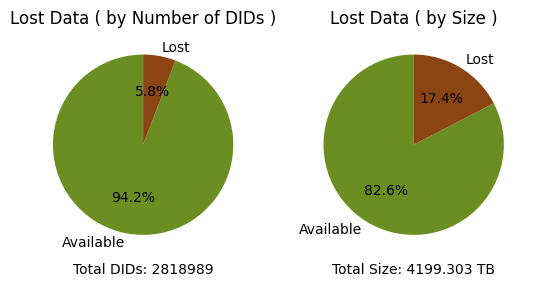

In [14]:
import matplotlib.pyplot as plt

labels = ['Available', 'Lost']
sizes = [total_size_rucio - size_lost_files, size_lost_files]

colors = ['olivedrab','saddlebrown']

fig, axs = plt.subplots(1, 2)

axs[0].pie([num_rucio_dids - lost_dids.shape[0], lost_dids.shape[0]], labels=['Available', 'Lost'], autopct='%1.1f%%', startangle=90, colors=colors)
axs[0].set_title('Lost Data ( by Number of DIDs )')
axs[0].set_xlabel(f'Total DIDs: {num_rucio_dids}')

axs[1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
axs[1].set_title('Lost Data ( by Size )')
axs[1].set_xlabel(f'Total Size: {bytesToTB(total_size_rucio)} TB')

plt.show()

## Dark DIDs Analysis

In [15]:
num_seal_dids = seal_dumps_concatenated_df['name'].nunique()
num_dark_dids = dark_dids['name'].nunique()
percentage_dark = round((dark_dids.shape[0] / num_seal_dids) * 100, 2)

print(f"Number of SEAL DIDs: {num_seal_dids}")
print(f"Number of Dark Files: {dark_dids.shape[0]}")
print(f"Percentage of Dark Data: {percentage_dark}%" )

Number of SEAL DIDs: 2654682
Number of Dark Files: 20
Percentage of Dark Data: 0.0%


In [16]:
total_size_seal = seal_dumps_concatenated_df['size'].sum()
size_dark_files = dark_dids['size'].sum()
percentage_dark_size = round((size_dark_files / total_size_seal) * 100, 2)

print(f"Total size of SEAL DIDs: {bytesToTB(total_size_seal)} TB")
print(f"Total size of Dark Data: {bytesToTB(size_dark_files)} TB")
print(f"Percentage of Dark Size: {percentage_dark_size}%")

Total size of SEAL DIDs: 3468.571 TB
Total size of Dark Data: 0.004 TB
Percentage of Dark Size: 0.0%


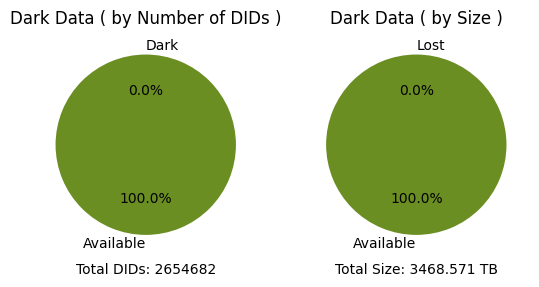

In [17]:
fig, axs = plt.subplots(1, 2)

sizes = [total_size_seal - size_dark_files, size_dark_files]

axs[0].pie([num_seal_dids - dark_dids.shape[0], dark_dids.shape[0]], labels=['Available', 'Dark'], autopct='%1.1f%%', startangle=90, colors=colors)
axs[0].set_title('Dark Data ( by Number of DIDs )')
axs[0].set_xlabel(f'Total DIDs: {num_seal_dids}')

axs[1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
axs[1].set_title('Dark Data ( by Size )')
axs[1].set_xlabel(f'Total Size: {bytesToTB(total_size_seal)} TB')



plt.show()

# Consistent DIDs

Consistent DIDs are present in both Rucio and SEAL dumps.

In [18]:
consistent_dids = rucio_dumps_df[rucio_dumps_df['path'].isin(seal_dumps_concatenated_df['path'])]

num_consistent_dids = consistent_dids['name'].nunique()
percentage_consistent = round((num_consistent_dids / num_rucio_dids) * 100, 2)

print(f"Number of Consistent DIDs: {num_consistent_dids}")
print(f"Percentage of Consistent DIDs: {percentage_consistent}%")

Number of Consistent DIDs: 2654663
Percentage of Consistent DIDs: 94.17%


In [19]:
size_consistent_files = consistent_dids['size'].sum()
percentage_consistent_size = round((size_consistent_files / total_size_rucio) * 100, 2)

print(f"Total size of Consistent DIDs: {bytesToTB(size_consistent_files)} TB")
print(f"Percentage of Consistent Size: {percentage_consistent_size}%")

Total size of Consistent DIDs: 3468.604 TB
Percentage of Consistent Size: 82.6%


# Save the results

In [21]:
start_date = time_range_start.strftime('%Y%m%d')
end_date = time_range_end.strftime('%Y%m%d')
lost_dids.to_csv(f'data/outputs/{start_date}-{end_date}_lost_dids.csv', index=False)
dark_dids.to_csv(f'data/outputs/{start_date}-{end_date}_dark_dids.csv', index=False)
consistent_dids.to_csv(f'data/outputs/_{start_date}-{end_date}_consistent_dids.csv', index=False)